# **Import Libraries and modules**

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import cv2
from skimage import io
from google.colab.patches import cv2_imshow

In [0]:
def pre_process_and_expand_dim(img):
    """[Rescale image to 224x224x3 (VGG's expectation),expand_dims to convert image to a batch of size 1,\
    Preprocesing normalizes our input image by subtracting mean RGB values]
    
    Arguments:
        img {[numpy.ndarray]} -- [image to be pre-processed]
    
    Returns:
        [numpy.ndarray] -- [original resized and pre-processed image with expanded dimension]
    """
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img,x
    

Let's start with a pretrained VGG model

In [3]:
model = VGG16(weights="imagenet")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

In [4]:
type(model)

tensorflow.python.keras.engine.training.Model

In [0]:
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog ,x= pre_process_and_expand_dim(dog)

# GRADCAM

In [0]:
def get_gradcam_img(x, model, layer_name, image, class_id = None):
  """[summary]
    
    Arguments:
        x {[numpy.ndarray]} -- [This is the pre-processed image (4D tensor) that would be passed through the model]
        model {[tensorflow.python.keras.engine.training.Model]} -- [model to be used for prediction]
        layer_name {[str]} -- [layer name for which heatmap is to be drawn]
        image {[numpy.ndarray]} -- [original resized image]
    
    Keyword Arguments:
        class_id {[type]} -- [This is the class for which the gradCAM heatmap is being generated for]
          (default: {If set to None the heatmaps are generated for the class that the model predicted})
  """
  preds = model.predict(x)#We get the predictions for the image
  if class_id is None:
    class_idx = np.argmax(preds[0])#We take the topmost class index
  else:
    class_idx = class_id
  #print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)#Take output from the desired convolutional layer

  grads = K.gradients(class_output, last_conv_layer.output)[0]#Compute the gradient of the class output value with respect to the feature map
  #print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))#Pool the gradients over all the axies leaving out the channel dimension
  #print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]#Weigh the output feature map with the computed gradient values
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)#Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
  #print(conv_layer_output_value.shape)
  #print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)#Normalize the heat map to make the values between 0 and 1

  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  cv2_imshow( image)
  cv2_imshow(superimposed_img)

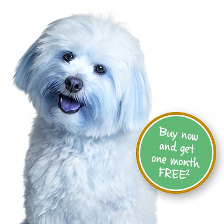

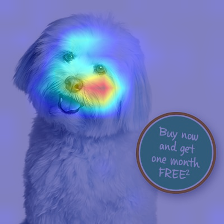

In [7]:
get_gradcam_img(x, model, "block5_conv3", dog, class_id = None)

### Finding sunglasses in the image

We first find the class id for sunglasses [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

*  836: 'sunglass',
*837: 'sunglasses, dark glasses, shades'

In [0]:
iron_man = io.imread("drive/My Drive/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
iron_man,x= pre_process_and_expand_dim(iron_man)

##  For Class id 836

#### Last layer output

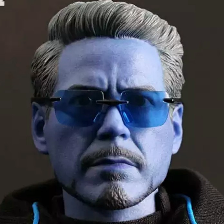

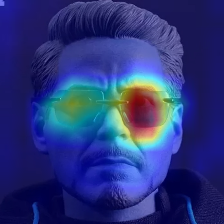

In [9]:
get_gradcam_img(x, model, "block5_conv3", iron_man, 836)

#### 2nd last layer output

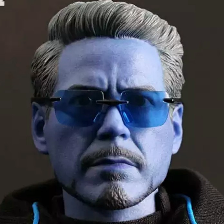

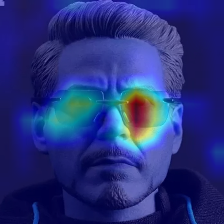

In [10]:
get_gradcam_img(x, model, "block5_conv2", iron_man, 836)

### 3rd last layer output

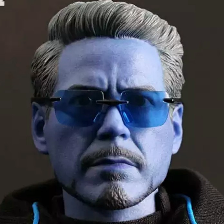

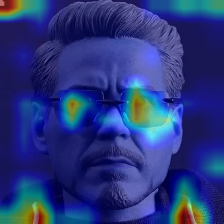

In [11]:
get_gradcam_img(x, model, "block5_conv1", iron_man, 836)

##  For Class id 837

#### Last layer output

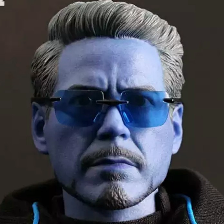

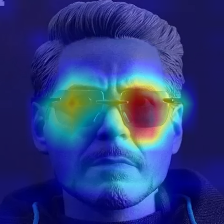

In [12]:
get_gradcam_img(x, model, "block5_conv3", iron_man, 837)

#### 2nd last layer output

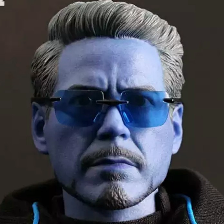

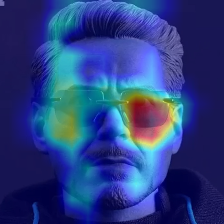

In [13]:
get_gradcam_img(x, model, "block5_conv2", iron_man, 837)

### 3rd last layer output

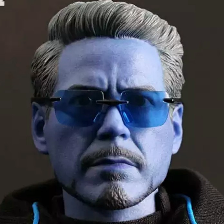

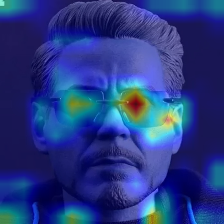

In [14]:
get_gradcam_img(x, model, "block5_conv1", iron_man, 837)

### Observations

* As we go deeper into the network - the layers start looking at specific parts of the image for specific classes

* The heatmap is more spread out in the shallower layers since they are looking for more generic features

